In [5]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [2]:
#setting cho tensorflow chạy bằng gpu
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load dataset

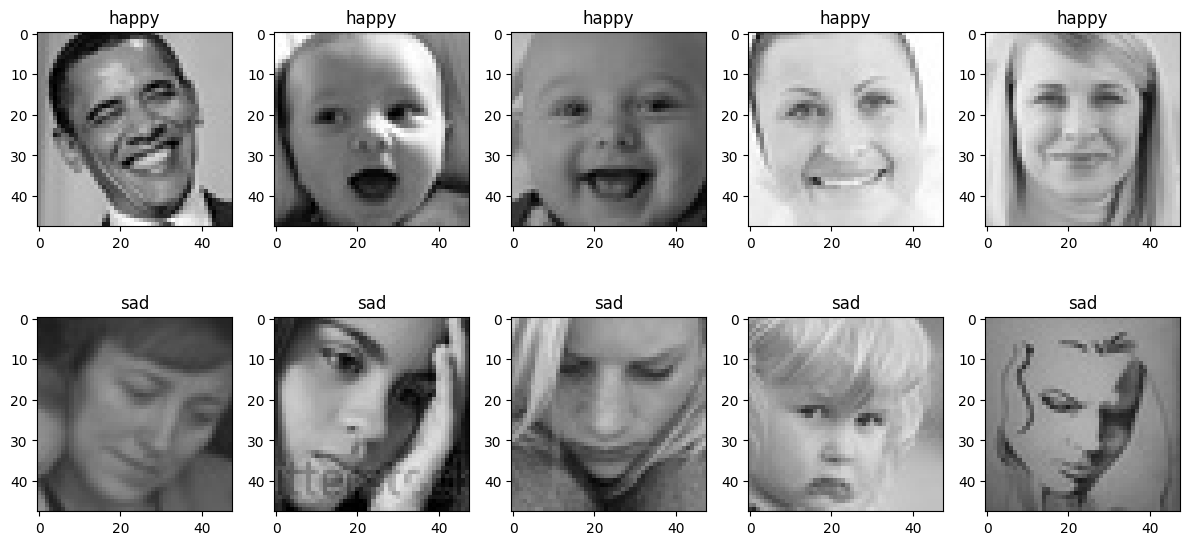

In [3]:
# Dữ liệu gồm tập các ảnh mặt buồn và vui
# Kích thước ảnh: 48*48 pixels
pic_size = 48

# file chứa dataset
base_path = "./data/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")
        plt.title(expression)

plt.tight_layout()
plt.show()

Tiền xử lý

In [4]:
# xây dựng dữ liệu để training
batch_size = 128
base_path = "./data/"


train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 12103 images belonging to 2 classes.
Found 2964 images belonging to 2 classes.


Xây dựng model

In [5]:
# số nhãn
nb_classes = 2

# Khởi tạo mạng CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       2

C:\Users\WINDOWS\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training

In [6]:
# Số lần chạy
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("model_weights_cnn.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(    
        train_generator,
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=epochs,
        validation_data = validation_generator,
        validation_steps = validation_generator.n//validation_generator.batch_size,
        callbacks=callbacks_list)

Epoch 1/50
94/94 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.5537
Epoch 1: val_accuracy improved from -inf to 0.61990, saving model to model_weights_cnn.h5
94/94 [==============================] - 22s 174ms/step - loss: 0.8217 - accuracy: 0.5537 - val_loss: 0.6838 - val_accuracy: 0.6199
Epoch 2/50
94/94 [==============================] - ETA: 0s - loss: 0.7365 - accuracy: 0.5903
Epoch 2: val_accuracy did not improve from 0.61990
94/94 [==============================] - 14s 152ms/step - loss: 0.7365 - accuracy: 0.5903 - val_loss: 0.6612 - val_accuracy: 0.6199
Epoch 3/50
94/94 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.6009
Epoch 3: val_accuracy did not improve from 0.61990
94/94 [==============================] - 14s 152ms/step - loss: 0.7179 - accuracy: 0.6009 - val_loss: 0.6603 - val_accuracy: 0.6199
Epoch 4/50
94/94 [==============================] - ETA: 0s - loss: 0.7030 - accuracy: 0.6139
Epoch 4: val_accuracy improved from 

Đồ thị

In [8]:
# tạo đồ thị
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# in ra lần thử tốt nhất

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

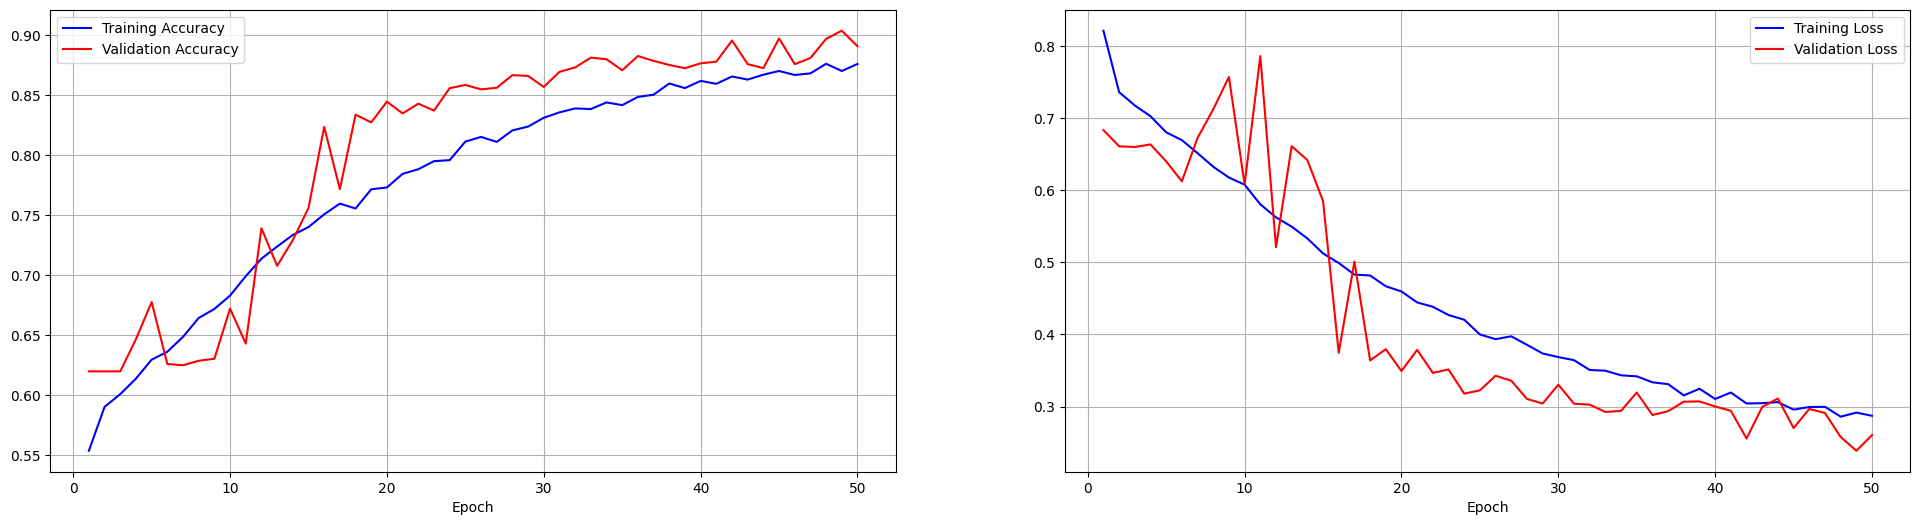

Best Validation Accuracy Score 0.90387, is for epoch 49


In [9]:
plot_results(history)
best_epoch =get_best_epcoh(history)

Testing

In [31]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2

In [32]:
loaded_model = load_model('model_weights_cnn.h5')

(56, 56, 1)


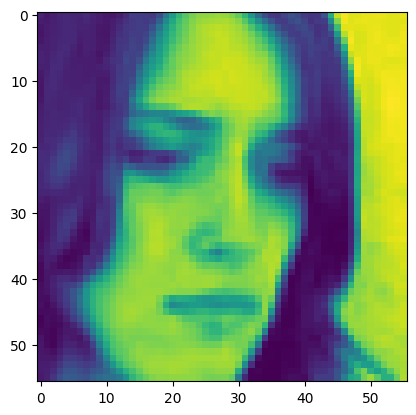

In [33]:
image = tf.io.read_file('./test/sad1.jpg')
image = tf.image.decode_image(image, channels=3)
gray_image = tf.image.rgb_to_grayscale(image)
resized_image = tf.image.resize(gray_image, [56, 56])
print(resized_image.shape)
plt.imshow(resized_image)

In [35]:
result = np.argmax(loaded_model.predict(np.expand_dims(resized_image/255, 0)))
result

1/1 [==============================] - 0s 164ms/step


1

In [36]:
if result == 0:
    print("happy")
if result == 1:
    print("sad")

sad
